In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [77]:
ads_data = pd.read_csv('../data/ads_data.csv.zip', parse_dates=['date'], compression='zip') # прочитать единственный файл в архиве

In [78]:
ads_data['full_date'] = pd.to_datetime(ads_data.time, unit='s')

In [134]:
ads_data.head()

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793,2019-04-01 00:00:48
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041,2019-04-01 16:24:26
2,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,41,2019-04-01 16:24:26
3,42987,1554135866,view,2019-04-01,CPM,0,28541,42985,ios,199.1,80160,898,2019-04-01 16:24:26
4,23456,1554135866,view,2019-04-01,CPM,0,5681,23456,web,190.0,125560,29,2019-04-01 16:24:26


### 1. Получить статистику по дням.
Посчитать число всех событий по дням, число показов, число кликов, число уникальных объявлений и уникальных кампаний.

<Axes: xlabel='date'>

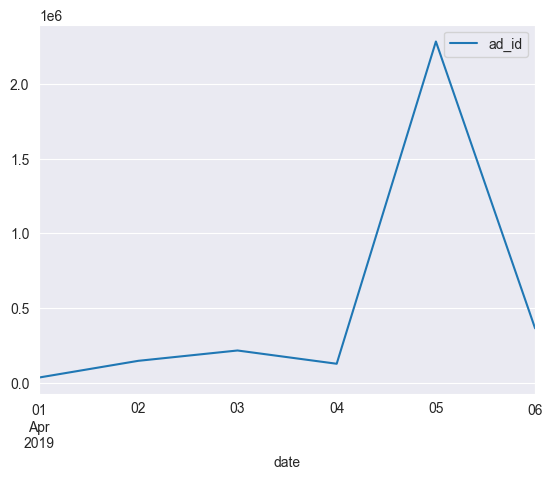

In [80]:
ads_data\
    .groupby('date') \
    .agg({'ad_id': 'count'}).plot()

In [81]:
# ??pd.pivot

In [82]:
ads_data\
    .groupby(['date', 'event'], as_index=False) \
    .agg({'ad_id': 'count'}) \
    .pivot(index='date', columns='event', values='ad_id')\
    .reset_index()

event,date,click,view
0,2019-04-01,735,34832
1,2019-04-02,1518,145811
2,2019-04-03,1678,214851
3,2019-04-04,1517,126182
4,2019-04-05,501595,1783288
5,2019-04-06,80420,284287


In [83]:
ads_data\
    .groupby(['date'], as_index=False) \
    .agg({'ad_id': pd.Series.nunique, 'campaign_union_id': pd.Series.nunique})

,date,ad_id,campaign_union_id
0,2019-04-01,49,49
1,2019-04-02,146,146
2,2019-04-03,179,177
3,2019-04-04,150,147
4,2019-04-05,131,130
5,2019-04-06,61,60


### 2. Разобраться, почему случился такой скачок 2019-04-05?
Каких событий стало больше?
У всех объявлений или только у некоторых?

In [84]:
ads_data[ads_data.date == '2019-04-05'] \
    .groupby('ad_id') \
    .agg({'time': 'count'}) \
    .sort_values('time', ascending=False) \
    .head()

,time
ad_id,
112583,2166611
29927,27186
44635,8268
46583,7327
44956,5656


In [85]:
ad_id = 112583

In [86]:
ads_data.query('ad_id == @ad_id').groupby('date').agg({'time': 'count'})

,time
date,
2019-04-05,2166611
2019-04-06,348613


In [87]:
ads_data.query('ad_id == @ad_id').head(1)

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
527124,112583,1554480636,view,2019-04-05,CPM,0,111818,112260,web,199.4,239408,4355,2019-04-05 16:10:36


Вывод: только ad_id = 112583 вызвал всплеск просмотров view 2019-04-05.

---
### 3. Найти топ 10 объявлений по CTR за все время.
        CTR — это отношение всех просмотров объявления к кликам.
Различается ли средний и медианный CTR объявлений в наших данных?

In [88]:
ads_data_by_ad = ads_data\
                        .groupby(['ad_id', 'event'], as_index=False) \
                        .agg({'time': 'count'}) \
                        .pivot(index='ad_id', columns='event', values='time')\
                        .reset_index()

ads_data_by_ad.head()

event,ad_id,click,view
0,3,9.0,490.0
1,2132,1.0,95.0
2,2276,2.0,1454.0
3,2475,NaN,132.0
4,2643,3.0,286.0


In [89]:
ads_data_by_ad = ads_data_by_ad.assign(
                                        ctr = ads_data_by_ad.click / ads_data_by_ad.view,
                                        ctr_per = ads_data_by_ad.click / ads_data_by_ad.view * 100
                                        )
ads_data_by_ad.head()

event,ad_id,click,view,ctr,ctr_per
0,3,9.0,490.0,0.018367,1.836735
1,2132,1.0,95.0,0.010526,1.052632
2,2276,2.0,1454.0,0.001376,0.137552
3,2475,NaN,132.0,NaN,NaN
4,2643,3.0,286.0,0.010490,1.048951


In [90]:
ads_data_by_ad.sort_values('ctr', ascending=False).head(10)

event,ad_id,click,view,ctr,ctr_per
289,112583,580436.0,1934788.0,0.300000,29.999979
324,119450,258.0,1254.0,0.205742,20.574163
125,38575,43.0,257.0,0.167315,16.731518
144,40968,29.0,217.0,0.133641,13.364055
207,45642,42.0,344.0,0.122093,12.209302
283,110924,11.0,95.0,0.115789,11.578947
194,45043,28.0,245.0,0.114286,11.428571
96,35034,112.0,997.0,0.112337,11.233701
5,4585,53.0,476.0,0.111345,11.134454
328,120347,236.0,2168.0,0.108856,10.885609


In [91]:
ads_data_by_ad.ctr.mean()

0.020628096080757954

In [92]:
ads_data_by_ad.ctr.median()

0.010753240746688594

<Axes: xlabel='ctr', ylabel='Count'>

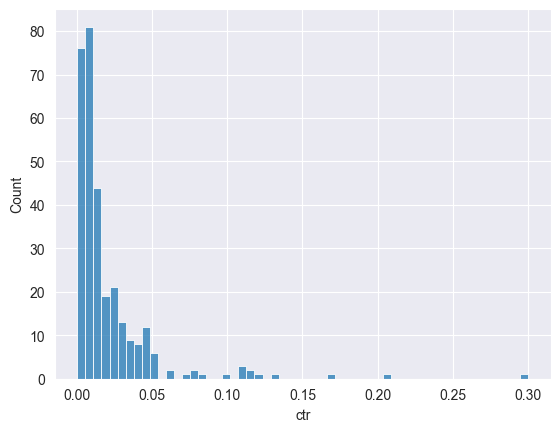

In [93]:
sns.histplot(data=ads_data_by_ad, x='ctr', kde=False)

Вывод: средний показатель выше медианного в 2 раза - происходит из-за перекоса распределения CTR влево (большое количество рекламы с низким CTR и немного с высоким).

---
### 4. Похоже, в наших логах есть баг, объявления приходят с кликами, но без показов!
Сколько таких объявлений?
Есть ли какие-то закономерности?
Эта проблема наблюдается на всех платформах?

In [111]:
ads_data_by_ad = ads_data_by_ad.fillna(0)
ads_data_by_ad.head()

event,ad_id,click,view,ctr,ctr_per
0,3,9.0,490.0,0.018367,1.836735
1,2132,1.0,95.0,0.010526,1.052632
2,2276,2.0,1454.0,0.001376,0.137552
3,2475,0.0,132.0,0.000000,0.000000
4,2643,3.0,286.0,0.010490,1.048951


In [115]:
ads_ids_bug = ads_data_by_ad.query('click == 0').ad_id
ads_ids_bug.head()

3      2475
26    16444
29    16678
30    16845
38    20871
Name: ad_id, dtype: int64

In [264]:
ads_bug_by_platform = ads_data[ads_data.ad_id.isin(ads_ids_bug)] \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .rename(columns={'ad_id': 'ads_count'})\
    .sort_values('ads_count')

ads_bug_by_platform

,platform,ads_count
2,web,1988
1,ios,3075
0,android,4906


In [265]:
ads_all_by_platform = ads_data \
    .groupby('platform', as_index=False) \
    .agg({'ad_id': 'count'}) \
    .rename(columns={'ad_id': 'ads_count'})\
    .sort_values('ads_count')

ads_all_by_platform

,platform,ads_count
2,web,635425
1,ios,953078
0,android,1588211


In [266]:
ads_bug_by_platform['percentage'] = ads_bug_by_platform.ads_count / ads_all_by_platform.ads_count * 100
ads_bug_by_platform

,platform,ads_count,percentage
2,web,1988,0.312861
1,ios,3075,0.322639
0,android,4906,0.308901


Вывод: примерно 0,3 % объявлений с багом на каждой платформе.

---
### 5. Есть ли различия в CTR у объявлений с видео и без?


In [137]:
ads_data_by_ad_with_video = ads_data_by_ad.merge(ads_data[['ad_id', 'has_video']], on='ad_id', how='left')
ads_data_by_ad_with_video

,ad_id,click,view,ctr,ctr_per,has_video
0,3,9.0,490.0,0.018367,1.836735,0
1,3,9.0,490.0,0.018367,1.836735,0
2,3,9.0,490.0,0.018367,1.836735,0
3,3,9.0,490.0,0.018367,1.836735,0
4,3,9.0,490.0,0.018367,1.836735,0
...,...,...,...,...,...,...
3176709,122086,50.0,1999.0,0.025013,2.501251,0
3176710,122086,50.0,1999.0,0.025013,2.501251,0
3176711,122086,50.0,1999.0,0.025013,2.501251,0
3176712,122086,50.0,1999.0,0.025013,2.501251,0


In [142]:
ctr_by_video = ads_data_by_ad_with_video.groupby('has_video')['ctr'].mean().reset_index()
ctr_by_video

,has_video,ctr
0,0,0.240271
1,1,0.002666


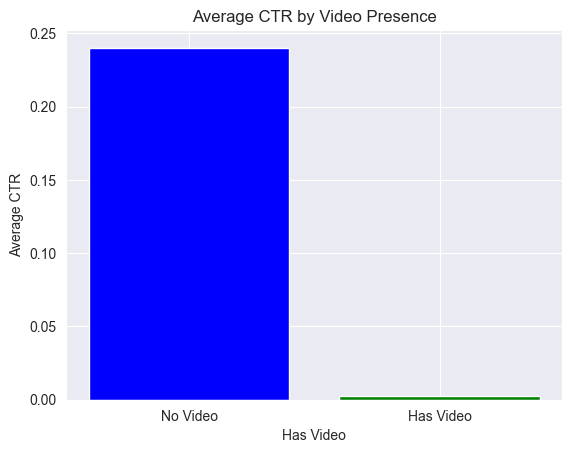

In [143]:
# Построение столбчатой диаграммы
plt.bar(ctr_by_video['has_video'], ctr_by_video['ctr'], color=['blue', 'green'])
plt.xlabel('Has Video')
plt.ylabel('Average CTR')
plt.title('Average CTR by Video Presence')
plt.xticks(ticks=ctr_by_video['has_video'], labels=['No Video', 'Has Video'])
plt.show()

Вывод: CTR рекламы без видео гораздо выше, чем с ним.

---
### 6. Чему равняется 95 процентиль CTR по всем объявлениям за 2019-04-04?


In [145]:
df_2019_04_04 =  ads_data[ads_data.date == '2019-04-04']\
                                                        .groupby(['ad_id', 'event'], as_index=False) \
                                                        .agg({'time': 'count'}) \
                                                        .pivot(index='ad_id', columns='event', values='time')\
                                                        .reset_index() \
                                                        .fillna(0)

df_2019_04_04.head()

event,ad_id,click,view
0,9071,3.0,352.0
1,9776,37.0,1115.0
2,10601,3.0,848.0
3,11887,151.0,8720.0
4,12137,1.0,170.0


In [146]:
df_2019_04_04['ctr'] = df_2019_04_04.click / df_2019_04_04.view

In [147]:
df_2019_04_04[df_2019_04_04.click > 0].ctr.quantile(q=0.95)

0.10211538461538454

---
### 7. Для финансового отчета нужно рассчитать заработок по дням.
        Мы списываем с клиентов деньги, если произошел клик по CPC объявлению, и мы списываем деньги за каждый показ CPM объявления, если у CPM объявления цена - 200 рублей, то за один показ мы зарабатываем 200 / 1000.

В какой день мы заработали больше всего?
В какой меньше?

In [201]:
# Расчет CPC заработка по дням
cpc_daily = ads_data[(ads_data['ad_cost_type'] == 'CPC') & (ads_data['event'] == 'click')]
# cpc_daily = ads_data.query("ad_cost_type == 'CPC' and event == 'click'")

cpc_daily.head(2)

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
248,4585,1554135960,click,2019-04-01,CPC,0,37,4382,android,53.5,327648,538,2019-04-01 16:26:00
880,120444,1554136218,click,2019-04-01,CPC,0,120413,120440,android,52.0,4667,874,2019-04-01 16:30:18


In [202]:
cpc_cost_daily = cpc_daily\
                            .groupby('date')['ad_cost']\
                            .sum()\
                            .reset_index(name='cpc_cost')

cpc_cost_daily

,date,cpc_cost
0,2019-04-01,7036.9
1,2019-04-02,7663.7
2,2019-04-03,38597.2
3,2019-04-04,26878.0
4,2019-04-05,4381.2
5,2019-04-06,253.0


In [203]:
cpm_daily = ads_data.query("ad_cost_type == 'CPM' and event == 'view'")
cpm_daily.head(2)

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
0,23456,1554076848,view,2019-04-01,CPM,0,5681,23456,android,190.0,125560,793,2019-04-01 00:00:48
1,111941,1554135866,view,2019-04-01,CPM,0,111793,111941,ios,215.2,32277,1041,2019-04-01 16:24:26


In [204]:
cpm_cost_daily = cpm_daily\
                            .groupby('date')\
                            .apply(lambda x: x['ad_cost'].sum() / 1000)\
                            .reset_index(name='cpm_cost')

cpm_cost_daily

,date,cpm_cost
0,2019-04-01,6122.8123
1,2019-04-02,26173.3051
2,2019-04-03,34612.3170
3,2019-04-04,19416.3568
4,2019-04-05,354178.5490
5,2019-04-06,56587.3376


In [207]:
combined_daily_costs = pd.merge(cpc_cost_daily, cpm_cost_daily, on='date', how='outer').sort_values(by='date')
combined_daily_costs['total_daily_cost'] = combined_daily_costs.cpc_cost + combined_daily_costs.cpm_cost
combined_daily_costs

,date,cpc_cost,cpm_cost,total_daily_cost
0,2019-04-01,7036.9,6122.8123,13159.7123
1,2019-04-02,7663.7,26173.3051,33837.0051
2,2019-04-03,38597.2,34612.3170,73209.5170
3,2019-04-04,26878.0,19416.3568,46294.3568
4,2019-04-05,4381.2,354178.5490,358559.7490
5,2019-04-06,253.0,56587.3376,56840.3376


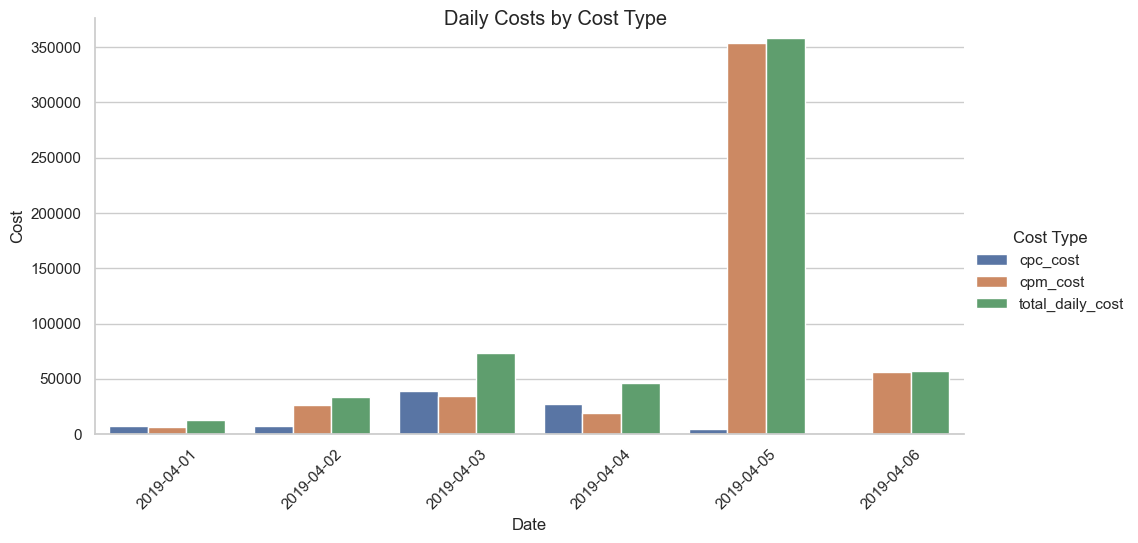

In [218]:
# Построение графика с использованием catplot для группировки по датам
# Сначала преобразуем данные для catplot, "расплавив" столбцы затрат в длинный формат
melted_costs = pd.melt(combined_daily_costs, id_vars='date', value_vars=['cpc_cost', 'cpm_cost', 'total_daily_cost'],
                       var_name='Cost Type', value_name='Cost')

# Использование catplot для создания графика
g = sns.catplot(x='date', y='Cost', hue='Cost Type', data=melted_costs, kind='bar', height=5, aspect=2)

# Настройка параметров отображения
g.fig.suptitle('Daily Costs by Cost Type')
g.set_xticklabels(rotation=45)
g.set_axis_labels("Date", "Cost")

# Отображение графика
plt.show()

Вывод:
- меньше всего заработали 2019-04-01
- больше всего заработали 2019-04-05 (за счет CPC)

---
### 8. Какая платформа самая популярная для размещения рекламных объявлений?


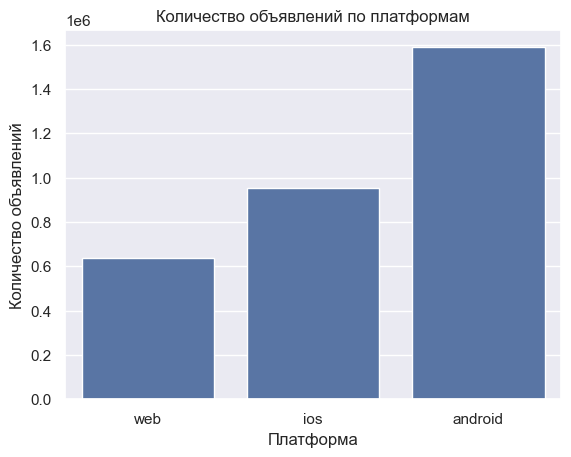

In [247]:
sns.barplot(data=ads_all_by_platform, x='platform', y='ads_count')

# Добавляем название графика и подписи осей
plt.title('Количество объявлений по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество объявлений')

# Отображаем график
plt.show()

---
### 9. Сколько процентов показов приходится на каждую из платформ?

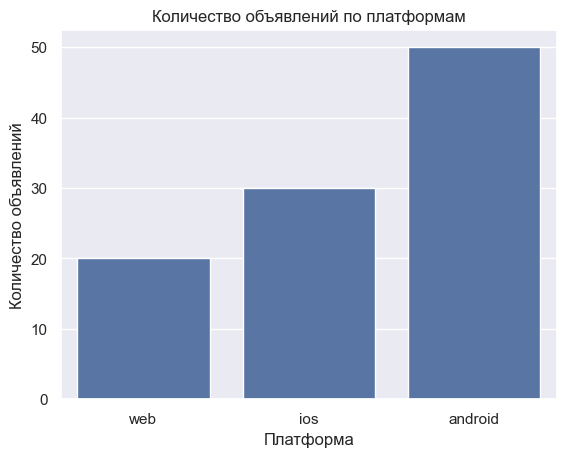

In [269]:
y = (ads_all_by_platform.ads_count / ads_all_by_platform.ads_count.sum()) * 100
sns.barplot(data=ads_all_by_platform, x='platform', y=y)

# Добавляем название графика и подписи осей
plt.title('Количество объявлений по платформам')
plt.xlabel('Платформа')
plt.ylabel('Количество объявлений')

# Отображаем график
plt.show()

---
 ### 10. А есть ли такие объявления, по которым сначала произошел клик, а только потом показ?

In [273]:
bug_ads = ads_data\
                    .groupby(['ad_id', 'event'], as_index=False) \
                    .agg({'time': 'min'}) \
                    .pivot(index='ad_id', columns='event', values='time').reset_index() \
                    .query('click < view')
bug_ads

event,ad_id,click,view
27,16548,1.554336e+09,1.554336e+09
81,30939,1.554165e+09,1.554173e+09
138,40464,1.554164e+09,1.554164e+09
158,42007,1.554423e+09,1.554423e+09
185,44543,1.554336e+09,1.554337e+09
201,45436,1.554336e+09,1.554336e+09
324,119450,1.554336e+09,1.554336e+09


In [272]:
ads_data[ads_data.ad_id == 16548].sort_values('time')

,ad_id,time,event,date,ad_cost_type,has_video,client_union_id,campaign_union_id,platform,ad_cost,target_audience_count,user_id,full_date
512690,16548,1554336083,click,2019-04-04,CPM,0,722,16523,ios,196.6,53199,4133,2019-04-04 00:01:23
511482,16548,1554336278,view,2019-04-04,CPM,0,722,16523,android,196.6,53199,3736,2019-04-04 00:04:38
511439,16548,1554336352,view,2019-04-04,CPM,0,722,16523,android,196.6,53199,4968,2019-04-04 00:05:52
511438,16548,1554336352,view,2019-04-04,CPM,0,722,16523,ios,196.6,53199,4206,2019-04-04 00:05:52
511437,16548,1554336352,view,2019-04-04,CPM,0,722,16523,web,196.6,53199,3898,2019-04-04 00:05:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2056433,16548,1554422265,view,2019-04-05,CPM,0,722,16523,android,196.6,53199,3613,2019-04-04 23:57:45
2056432,16548,1554422265,view,2019-04-05,CPM,0,722,16523,android,196.6,53199,6044,2019-04-04 23:57:45
2056461,16548,1554422308,view,2019-04-05,CPM,0,722,16523,ios,196.6,53199,5831,2019-04-04 23:58:28
2056652,16548,1554422338,view,2019-04-05,CPM,0,722,16523,android,196.6,53199,2837,2019-04-04 23:58:58


In [276]:
bug_ads.ad_id.to_list()

[16548, 30939, 40464, 42007, 44543, 45436, 119450]

Вывод: [16548, 30939, 40464, 42007, 44543, 45436, 119450] - список объявлений, где клик был до показа.